# General TF Pipelines

We ususally have data stored in some format and then we load it, split it into train, validation and test splits and then we transform it according to our needs, shuffle it if we need shuffled data and then batch it into a specific batch sizes before we can directly use it for our model training/testing purposes.


General File formats are:
- csv
- images inside folders with filename or folder name as labels
- text data in 1 data per line format in a text file
- numpy/pandas dump on hard disks
- tf record dump on hard disks


Most of this can be easily read and dealt with when we use them through Tensorflow Pipelines thus also helping us to future proof the ETL process so that we can directly feed the pipeline raw data in a general format and still expect the model to work properly

## CSV Files

### Reading Small files(using Pandas DF)

- In case of float and int data only

    For small files available in .csv format which can be directly loaded into the memory and occupy very less space in the memory, we can do the following
    - Read the data using pandas.read_csv() api
    - separate the features and label in separate dataframes
    - Normalize the features by using `tensorflow.keras.layers.experimental.preprocessing.Normalization()`
    - create a model with the above created Normalized layer object as the 1st layer to treat it as input
    - during model.fit() directly pass the pandas feature dataframe and label dataframe, normalization will be taken care by the `Normalization` layer

- In case of Mixed data in CSV


    If the csv contains mixed data like categorical and string data which needs preprocessing before it is fed to the model we do the following:
    - Read the data using pandas.read_csv() api
    - Separate the feature and label in separate dataframes
    - Use proper feature columns to convert the string or categorical data to int, float or one-hot encoded data
    - Create a model object which will handle the preprocessing (lets call it preprocessing_model)
    - Create a model on top of the preprocessing_model

Eg: Using Mixed Data in CSV


the dataset can be found [here](https://storage.googleapis.com/tf-datasets/titanic/train.csv)

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras

In [2]:
titanic_df = pd.read_csv('dataset/titanic_train.csv')
titanic_df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [3]:
titanic_features_df = titanic_df.copy()
titanic_label_df = titanic_features_df.pop('survived')

**Create Input Processing Model**

Here we will use a preprocessing model where we use the feature columns to create the model so that the raw csv can be fed to this model which will preprocess the data and feed the actual model the converted data.

First we need to define a tensor of proper dtype so as to ease the automation of data conversion. This is just empty list of tensors defining the input columns that we are going to preprocess later

In [4]:
simple_input_features_dict = {}

for name, col in titanic_features_df.items():
    print('Creaating empty tensor for column: ', name)
    dtype = col.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32
    simple_input_features_dict[name] = keras.Input(shape=(1,), name=name, dtype=dtype)
    
simple_input_features_dict

Creaating empty tensor for column:  sex
Creaating empty tensor for column:  age
Creaating empty tensor for column:  n_siblings_spouses
Creaating empty tensor for column:  parch
Creaating empty tensor for column:  fare
Creaating empty tensor for column:  class
Creaating empty tensor for column:  deck
Creaating empty tensor for column:  embark_town
Creaating empty tensor for column:  alone


{'sex': <tf.Tensor 'sex:0' shape=(None, 1) dtype=string>,
 'age': <tf.Tensor 'age:0' shape=(None, 1) dtype=float32>,
 'n_siblings_spouses': <tf.Tensor 'n_siblings_spouses:0' shape=(None, 1) dtype=float32>,
 'parch': <tf.Tensor 'parch:0' shape=(None, 1) dtype=float32>,
 'fare': <tf.Tensor 'fare:0' shape=(None, 1) dtype=float32>,
 'class': <tf.Tensor 'class:0' shape=(None, 1) dtype=string>,
 'deck': <tf.Tensor 'deck:0' shape=(None, 1) dtype=string>,
 'embark_town': <tf.Tensor 'embark_town:0' shape=(None, 1) dtype=string>,
 'alone': <tf.Tensor 'alone:0' shape=(None, 1) dtype=string>}

This is where we start defining the preprocessing for each column.

We first define the preprocessing of the float/int columns. Here we are just going to define that we need to normaize these columns before feeding it to the model.

In [5]:
numeric_col_input_dict = { name:input for name, input, in simple_input_features_dict.items()
                         if input.dtype == tf.float32 }

In [6]:
numeric_col_input_dict

{'age': <tf.Tensor 'age:0' shape=(None, 1) dtype=float32>,
 'n_siblings_spouses': <tf.Tensor 'n_siblings_spouses:0' shape=(None, 1) dtype=float32>,
 'parch': <tf.Tensor 'parch:0' shape=(None, 1) dtype=float32>,
 'fare': <tf.Tensor 'fare:0' shape=(None, 1) dtype=float32>}

In [7]:
numeric_col_input_dict.keys()

dict_keys(['age', 'n_siblings_spouses', 'parch', 'fare'])

Here we are concatenating all the numeric columns into a single column just to handle them at the same time. Else we can create Normalization layer for each numeric column and handle thems separately

In [8]:
x = keras.layers.Concatenate()(list(numeric_col_input_dict.values()))
normalzied_layer = keras.layers.experimental.preprocessing.Normalization()
normalzied_layer.adapt(np.array(titanic_df[numeric_col_input_dict.keys()]))
all_numeric_input = normalzied_layer(x)

all_numeric_input

<tf.Tensor 'normalization/truediv:0' shape=(None, 4) dtype=float32>

Now we define the prepreprocesing for the other non_numeric inputs

For the non_numeric columsn we are going to define a simple preprocessing i.e converting the string into a one-hot encoded vector.

We use the `keras.layers.experimental.preprocessin.StrngLookup` api to create a vocabulary list and map the string to integer values. Then we use the `keras.layers.experimental.preprocessing.CategoryEncoding` to convert the integers into float32 appropriate data i.e. basically creating a one-hot encoded vector of the integer values.

Note: we can also use `layers.Embedding`

In [10]:
other_inputs_dict = {}
for name, input in simple_input_features_dict.items():
    if input.dtype != tf.float32:
        print('Defining processing for column: ', name)
        lookup = keras.layers.experimental.preprocessing.StringLookup(vocabulary=np.unique(titanic_df[name]))
        one_hot = keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())
        
        x = lookup(input)
        x = one_hot(x)
        other_inputs_dict[name]=x
        
other_inputs_dict

Defining processing for column:  sex
Defining processing for column:  class
Defining processing for column:  deck
Defining processing for column:  embark_town
Defining processing for column:  alone


{'sex': <tf.Tensor 'category_encoding/bincount/DenseBincount:0' shape=(None, 4) dtype=float32>,
 'class': <tf.Tensor 'category_encoding_1/bincount/DenseBincount:0' shape=(None, 5) dtype=float32>,
 'deck': <tf.Tensor 'category_encoding_2/bincount/DenseBincount:0' shape=(None, 10) dtype=float32>,
 'embark_town': <tf.Tensor 'category_encoding_3/bincount/DenseBincount:0' shape=(None, 6) dtype=float32>,
 'alone': <tf.Tensor 'category_encoding_4/bincount/DenseBincount:0' shape=(None, 4) dtype=float32>}

**Now we will define a list with all the feature columns**

In [15]:
all_inputs = []
all_inputs.append(all_numeric_input)
for key, value in other_inputs_dict.items():
    all_inputs.append(value)
    
all_inputs

[<tf.Tensor 'normalization/truediv:0' shape=(None, 4) dtype=float32>,
 <tf.Tensor 'category_encoding/bincount/DenseBincount:0' shape=(None, 4) dtype=float32>,
 <tf.Tensor 'category_encoding_1/bincount/DenseBincount:0' shape=(None, 5) dtype=float32>,
 <tf.Tensor 'category_encoding_2/bincount/DenseBincount:0' shape=(None, 10) dtype=float32>,
 <tf.Tensor 'category_encoding_3/bincount/DenseBincount:0' shape=(None, 6) dtype=float32>,
 <tf.Tensor 'category_encoding_4/bincount/DenseBincount:0' shape=(None, 4) dtype=float32>]

**Now we create a preprocessing-model with all the feature columns so as to create a input layer with the same preprocessing functionality for the actual model we need to train**

For the model, we use the smple empty list of tensors as the input and use the tensors created using feature column and defining the preprocessing step as the intermediate and a concatenated layer of all the feature columns as output

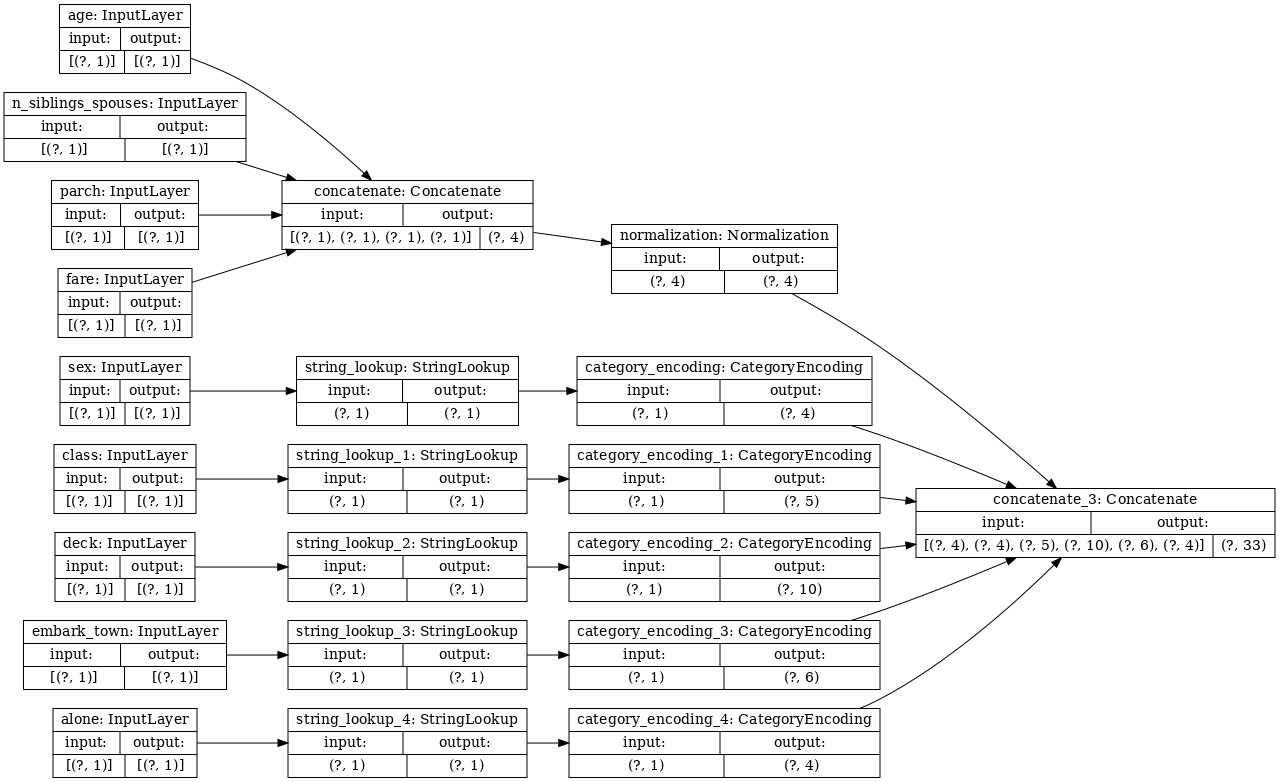

In [17]:
preprocessed_inputs_concat = keras.layers.Concatenate()(all_inputs)
titanic_preprocessing_model = keras.Model(simple_input_features_dict, preprocessed_inputs_concat)
keras.utils.plot_model(model=titanic_preprocessing_model, rankdir='LR', dpi=72, show_shapes=True)

**Testing the Model**

If we look at the model, it expects that the data will be in some form of dictionary where each key value pair will be have the key as the column name and the value will be each value from each row for that column. Thus to get that format we need to create a new object containing the data in that specific format

In [19]:
titanic_features_dict = {name: np.array(value) for name, value in titanic_features_df.items()}

In [20]:
for name, values in titanic_features_dict.items():
    print(name,' : ', values[:5])

sex  :  ['male' 'female' 'female' 'female' 'male']
age  :  [22. 38. 26. 35. 28.]
n_siblings_spouses  :  [1 1 0 1 0]
parch  :  [0 0 0 0 0]
fare  :  [ 7.25   71.2833  7.925  53.1     8.4583]
class  :  ['Third' 'First' 'Third' 'First' 'Third']
deck  :  ['unknown' 'C' 'unknown' 'C' 'unknown']
embark_town  :  ['Southampton' 'Cherbourg' 'Southampton' 'Southampton' 'Queenstown']
alone  :  ['n' 'n' 'y' 'n' 'y']


In [21]:
example_data = {name:values[:2] for name, values in titanic_features_dict.items()}
example_data

{'sex': array(['male', 'female'], dtype=object),
 'age': array([22., 38.]),
 'n_siblings_spouses': array([1, 1]),
 'parch': array([0, 0]),
 'fare': array([ 7.25  , 71.2833]),
 'class': array(['Third', 'First'], dtype=object),
 'deck': array(['unknown', 'C'], dtype=object),
 'embark_town': array(['Southampton', 'Cherbourg'], dtype=object),
 'alone': array(['n', 'n'], dtype=object)}

In [20]:
titanic_preprocessing_model(example_data)

<tf.Tensor: shape=(2, 33), dtype=float32, numpy=
array([[-0.6104149 ,  0.39519805, -0.4790527 , -0.4974028 ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ],
       [ 0.66939706,  0.39519805, -0.4790527 ,  0.6763534 ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.   

As we can see that we took an example of 2 data points, and the model converted them into a proper format than can be directly fed to any keras model

**Now we build a model on top of this**

We will build a 2 models.
- 1st model will be a temporary model where we define the 2 dense layers which we will train.
The preprocessing_model will be given as input to this temporary model.
- 2nd model will be the actual model. We use the simple empty tensors as the input to this model and the output of the temporary model as the output of this model.

So our basic model structure is as follows:
- input ----------[Simple Empty Tensors]
- Preprocessing---[Preprocessing Model]
- Training----------[Temporary Model]
- Result---------[Output of Temp Model]

In [26]:
def get_titanic_model(preprocessing_model, input_dict):
    model_body = keras.Sequential([
        keras.layers.Dense(64),
        keras.layers.Dense(1)
    ])
    preprocessed_model_inputs = preprocessing_model(input_dict)
    result = model_body(preprocessed_model_inputs)
    model = keras.Model(input_dict, result)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [27]:
titanic_model = get_titanic_model(titanic_preprocessing_model, input_features_dict)

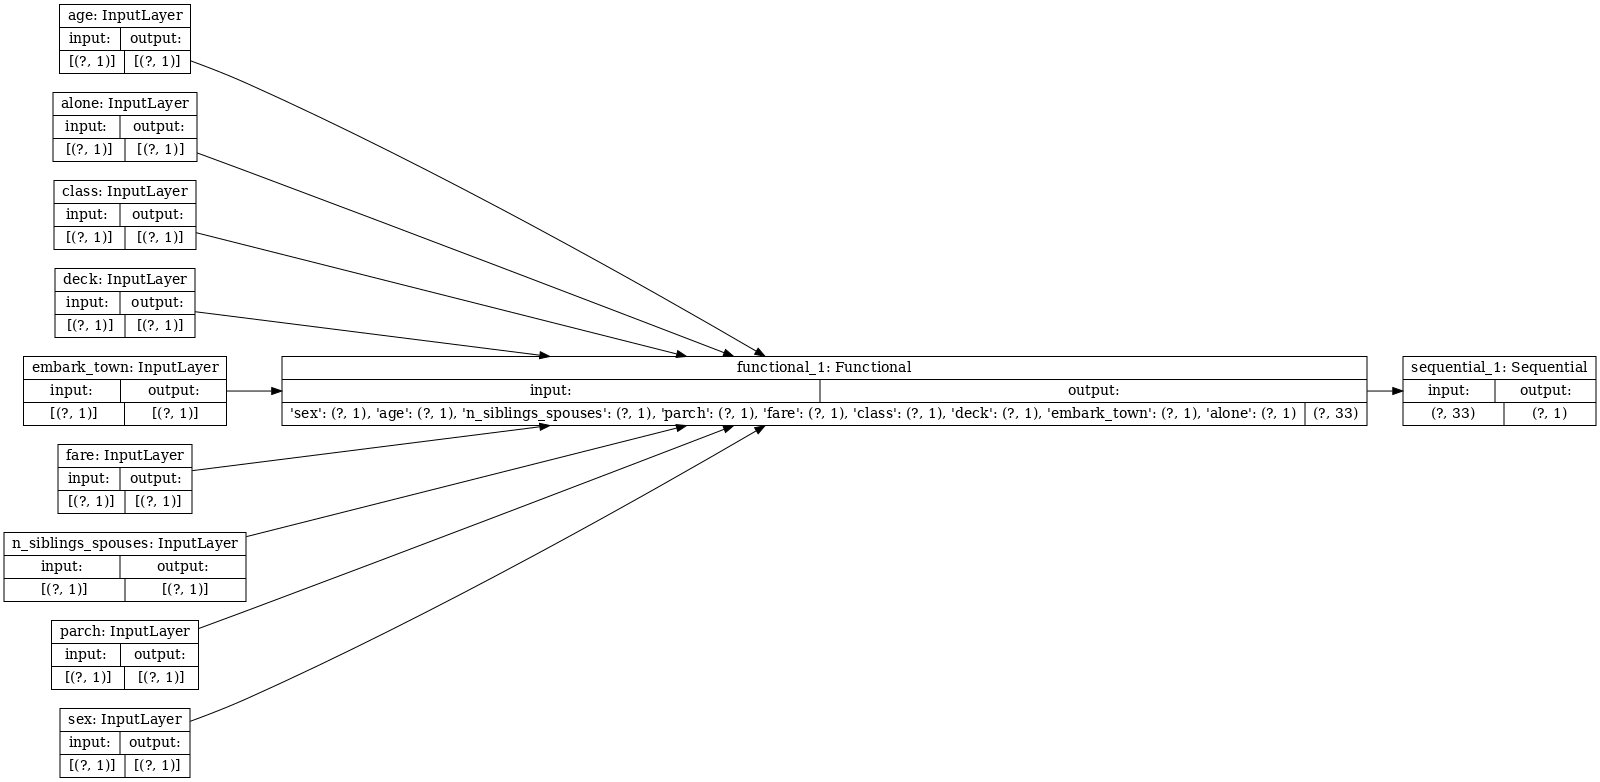

In [28]:
keras.utils.plot_model(model=titanic_model, rankdir='LR', dpi=72, show_shapes=True)

In [29]:
titanic_model.fit(x=titanic_features_dict, y=titanic_label_df, epochs=10)

Epoch 1/10
20/20 [==============================] - 0s 5ms/step - loss: 1.6210 - accuracy: 0.6826
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 0.8107 - accuracy: 0.7049
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.7066 - accuracy: 0.7799
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 0.5777 - accuracy: 0.8070
Epoch 5/10
20/20 [==============================] - 0s 9ms/step - loss: 0.5101 - accuracy: 0.8086
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 0.4899 - accuracy: 0.8070
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 0.5092 - accuracy: 0.8086
Epoch 8/10
20/20 [==============================] - 0s 3ms/step - loss: 0.5294 - accuracy: 0.8070
Epoch 9/10
20/20 [==============================] - 0s 4ms/step - loss: 0.4619 - accuracy: 0.8038
Epoch 10/10
20/20 [==============================] - 0s 7ms/step - loss: 0.4451 - accuracy: 0.8118


**Now when we save the model(titanic_model), the whole pipeline will be saved, as the preprocessing model is also now a part of the titanic_model.**

### For working with large data

When we are working with large amount of data that doesnt fit into the memory at once or we need more granular control over the data so that we can shuffle/batch on our own we need to use the `tf.data` apis for that

To create a  dataset from csv file either directly or through pandas we can do either of the following:
- Load from dataframe transformed into dictionary data
    ```python
    features_ds = tf.data.Dataset.from_tensor_slices((<data in dictionary format and not dataframe format directly>, <label data df>))
    # to itterate over the dataset we can do the following:
    for batch in features_ds:
        for name, value in batch.items():
            print(f"{name:19s}: {value}")
        break
    ```
    
- Load from .csv file itself
    ```python
    data_file_path = tf.keras.utils.get_file("<filename>.csv", "<location/url of the file>")
    data_csv_ds = tf.data.experimental.make_csv_dataset(
        data_file_path,
        batch_size=5, # Artificially small to make examples easier to show.
        label_name='<name of the column to be used as label>',
        num_epochs=1,
        ignore_errors=True)

    for batch, label in data_csv_ds.take(1):
        for key, value in batch.items():
            print(f"{key:20s}: {value[:5]}")
        print()
        print(f"{'label':20s}: {label[:5]}")
    ```

- Load from .gz file directly
    ```python
    data_gz_path = tf.keras.utils.get_file("<filename>.csv.gz", "<location/url of the file>")
    data_gz_ds = tf.data.experimental.make_csv_dataset(
        data_gz_path,
        batch_size=256, # Artificially small to make examples easier to show.
        label_name='<name of the column to be used as label>',
        num_epochs=1,
        compression_type='GZIP')

    for batch, label in data_gz_ds.take(1):
        for key, value in batch.items():
            print(f"{key:20s}: {value[:5]}")
        print()
        print(f"{'label':20s}: {label[:5]}")
    ```

### Loading Multiple Files


To load all the csv files in a given folder we can use glob style file patterns to match the specific csv files. In this case we use the `experimental.make_csv_dataset` api. 

Note: `num_parallel_reads` mark the number of files that it can read in parallel and jumble up together.

Note: The order of the files are shuffled in each itteration.


eg:
```python
ds = tf.data.experimental.make_csv_dataset(
    file_pattern='*.csv',
    batch_size=128,
    num_epochs=1,
    num_parallel_reads=20,
    shuffle_buffer_size=10000
)
```

## Numpy Format Data files

Files stored in the `.npz` extension are usually numpy objects stored in the hard disk. Using Tensorflow pipelines we can work with the numpy files directly without needing to work on them too much.

eg:
```python
path = tf.keras.utils.get_file('<file name.npz>', 'path/url to the file')

with np.load(path) as data:
    train = data['train']
    test = data['test']
    
# code to separate features and labels
# train_feat = ??
# traian_label = ??
# test_feat = ??
# test_label = ??
    
train_ds = tf.data.dataset.from_tensor_slices((train_feat, train_label)).shuffle(100).batch(128)
test_ds = tf.data.dataset.from_tensor_slices((test_feat, test_label)).batch(128)
```

## Working with Pandas Dataframe

the dataset can be found [here](https://storage.googleapis.com/tf-datasets/titanic/train.csv)

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras

In [2]:
titanic_df = pd.read_csv('dataset/titanic_train.csv')
titanic_df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [3]:
titanic_features_df = titanic_df.copy()
titanic_label_df = titanic_features_df.pop('survived')

**Create Input Processing Model**

Here we will use a preprocessing model where we use the feature columns to create the model so that the raw csv can be fed to this model which will preprocess the data and feed the actual model the converted data.

First we need to define a tensor of proper dtype so as to ease the automation of data conversion. This is just empty list of tensors defining the input columns that we are going to preprocess later

In [4]:
simple_input_features_dict = {}

for name, col in titanic_features_df.items():
    print('Creaating empty tensor for column: ', name)
    dtype = col.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32
    simple_input_features_dict[name] = keras.Input(shape=(1,), name=name, dtype=dtype)
    
simple_input_features_dict

Creaating empty tensor for column:  sex
Creaating empty tensor for column:  age
Creaating empty tensor for column:  n_siblings_spouses
Creaating empty tensor for column:  parch
Creaating empty tensor for column:  fare
Creaating empty tensor for column:  class
Creaating empty tensor for column:  deck
Creaating empty tensor for column:  embark_town
Creaating empty tensor for column:  alone


{'sex': <tf.Tensor 'sex:0' shape=(None, 1) dtype=string>,
 'age': <tf.Tensor 'age:0' shape=(None, 1) dtype=float32>,
 'n_siblings_spouses': <tf.Tensor 'n_siblings_spouses:0' shape=(None, 1) dtype=float32>,
 'parch': <tf.Tensor 'parch:0' shape=(None, 1) dtype=float32>,
 'fare': <tf.Tensor 'fare:0' shape=(None, 1) dtype=float32>,
 'class': <tf.Tensor 'class:0' shape=(None, 1) dtype=string>,
 'deck': <tf.Tensor 'deck:0' shape=(None, 1) dtype=string>,
 'embark_town': <tf.Tensor 'embark_town:0' shape=(None, 1) dtype=string>,
 'alone': <tf.Tensor 'alone:0' shape=(None, 1) dtype=string>}

This is where we start defining the preprocessing for each column.

We first define the preprocessing of the float/int columns. Here we are just going to define that we need to normaize these columns before feeding it to the model.

In [5]:
numeric_col_input_dict = { name:input for name, input, in simple_input_features_dict.items()
                         if input.dtype == tf.float32 }

In [6]:
numeric_col_input_dict

{'age': <tf.Tensor 'age:0' shape=(None, 1) dtype=float32>,
 'n_siblings_spouses': <tf.Tensor 'n_siblings_spouses:0' shape=(None, 1) dtype=float32>,
 'parch': <tf.Tensor 'parch:0' shape=(None, 1) dtype=float32>,
 'fare': <tf.Tensor 'fare:0' shape=(None, 1) dtype=float32>}

In [7]:
numeric_col_input_dict.keys()

dict_keys(['age', 'n_siblings_spouses', 'parch', 'fare'])

Here we are concatenating all the numeric columns into a single column just to handle them at the same time. Else we can create Normalization layer for each numeric column and handle thems separately

In [8]:
x = keras.layers.Concatenate()(list(numeric_col_input_dict.values()))
normalzied_layer = keras.layers.experimental.preprocessing.Normalization()
normalzied_layer.adapt(np.array(titanic_df[numeric_col_input_dict.keys()]))
all_numeric_input = normalzied_layer(x)

all_numeric_input

<tf.Tensor 'normalization/truediv:0' shape=(None, 4) dtype=float32>

Now we define the prepreprocesing for the other non_numeric inputs

For the non_numeric columsn we are going to define a simple preprocessing i.e converting the string into a one-hot encoded vector.

We use the `keras.layers.experimental.preprocessin.StrngLookup` api to create a vocabulary list and map the string to integer values. Then we use the `keras.layers.experimental.preprocessing.CategoryEncoding` to convert the integers into float32 appropriate data i.e. basically creating a one-hot encoded vector of the integer values.

Note: we can also use `layers.Embedding`

In [10]:
other_inputs_dict = {}
for name, input in simple_input_features_dict.items():
    if input.dtype != tf.float32:
        print('Defining processing for column: ', name)
        lookup = keras.layers.experimental.preprocessing.StringLookup(vocabulary=np.unique(titanic_df[name]))
        one_hot = keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())
        
        x = lookup(input)
        x = one_hot(x)
        other_inputs_dict[name]=x
        
other_inputs_dict

Defining processing for column:  sex
Defining processing for column:  class
Defining processing for column:  deck
Defining processing for column:  embark_town
Defining processing for column:  alone


{'sex': <tf.Tensor 'category_encoding/bincount/DenseBincount:0' shape=(None, 4) dtype=float32>,
 'class': <tf.Tensor 'category_encoding_1/bincount/DenseBincount:0' shape=(None, 5) dtype=float32>,
 'deck': <tf.Tensor 'category_encoding_2/bincount/DenseBincount:0' shape=(None, 10) dtype=float32>,
 'embark_town': <tf.Tensor 'category_encoding_3/bincount/DenseBincount:0' shape=(None, 6) dtype=float32>,
 'alone': <tf.Tensor 'category_encoding_4/bincount/DenseBincount:0' shape=(None, 4) dtype=float32>}

**Now we will define a list with all the feature columns**

In [15]:
all_inputs = []
all_inputs.append(all_numeric_input)
for key, value in other_inputs_dict.items():
    all_inputs.append(value)
    
all_inputs

[<tf.Tensor 'normalization/truediv:0' shape=(None, 4) dtype=float32>,
 <tf.Tensor 'category_encoding/bincount/DenseBincount:0' shape=(None, 4) dtype=float32>,
 <tf.Tensor 'category_encoding_1/bincount/DenseBincount:0' shape=(None, 5) dtype=float32>,
 <tf.Tensor 'category_encoding_2/bincount/DenseBincount:0' shape=(None, 10) dtype=float32>,
 <tf.Tensor 'category_encoding_3/bincount/DenseBincount:0' shape=(None, 6) dtype=float32>,
 <tf.Tensor 'category_encoding_4/bincount/DenseBincount:0' shape=(None, 4) dtype=float32>]

**Now we create a preprocessing-model with all the feature columns so as to create a input layer with the same preprocessing functionality for the actual model we need to train**

For the model, we use the smple empty list of tensors as the input and use the tensors created using feature column and defining the preprocessing step as the intermediate and a concatenated layer of all the feature columns as output

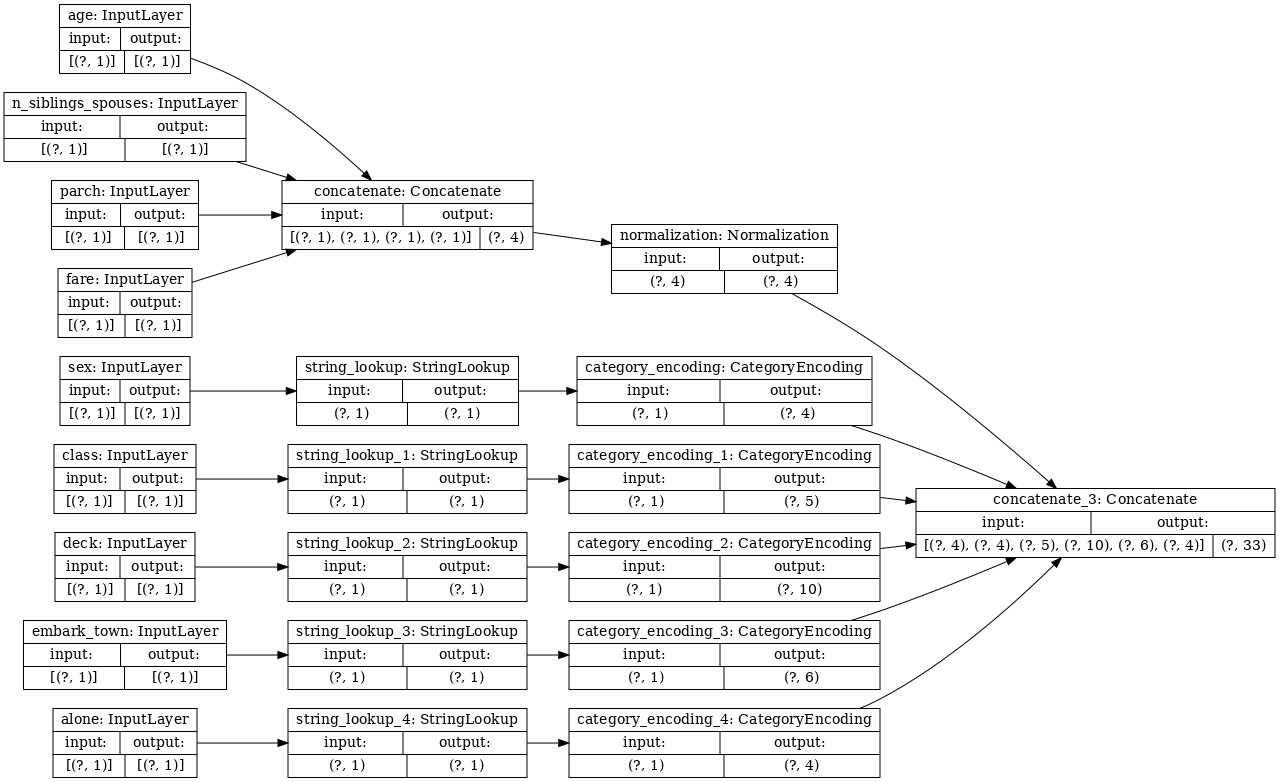

In [17]:
preprocessed_inputs_concat = keras.layers.Concatenate()(all_inputs)
titanic_preprocessing_model = keras.Model(simple_input_features_dict, preprocessed_inputs_concat)
keras.utils.plot_model(model=titanic_preprocessing_model, rankdir='LR', dpi=72, show_shapes=True)

## Working with Raw Files i.e. Images

### Using Generators

We can either use generators provided by tensorflow if all the images are neatly availabale in separate folders and nicely split based on trainaing and testing folder and each image is then put into separate folder based on its label. In such a scenario generators can easily load the data from the directory and maintain training and testing datasets with each image mapped to its proper label.

It can also be used if we have a file which has the structre that we need and the image paths in it. This file can be read as a pandas dataframe and can be parsed by the generators and we can easily get our datasets ready.

### Using tf.data

In this scenario we get a full control over the files and how they are read. So in this case we need to define each of the things separately. We need to define the basic folder structure that will be used for testing dataset and training dataset. **We can also use tar files directly in this scenario** 

eg:
```python
tar_url = '<the tar file url/location>'
data_root_path = tf.keras.utils.get_file(origin=tar_url, fname='root folder name of the dataset', untar=True)

file_location = pathlib.Path(data_root_path)

# collect all the files in the directory
all_images = [str(path) for path in list(file_location.glob('*/*'))]

# create a list of labels
label_names = sorted(item.name for item in file_location.glob('*/') if item.is_dir())
label_index dict((name, index) for index, name in enumberate(label_names))

# map images to label index
image_label_map = [label_index[pathlib.Path(path).parent.name] for path in all_images]

# datasets
image_path_dataset = tf.data.Datasets.from_tensor_slices(all_images)
label_dataset = tf.data.Datasets.from_tensor_slices(image_label_map)

# image reading and performing preprocessing
def read_img(path):
    image = tf.io.read_file(path)
    imgae = tf.image.decode_jpeg(image, channel=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0
    # we can perform other kinds of preprocessing if needed
    return image

image_dataset = image_path_dataset.map(read_img)
image_label_dataset = tf.data.Dataset.zip((image_dataset, label_dataset))
```